In [1]:
%%bash
# Extract raw data
tar -zxf ../raw_data/20190509.tar.gz -C ../raw_data

In [2]:
%matplotlib inline

# Import packages
import pandas as pd
import datetime as dt
import os

# Import user-defined module with regression and plotting functions
from src.calibrate import *

meas_day = "20190509"
data_directory = "../raw_data/"+meas_day+"/"

# Reformat measurement day to the format that GC uses
dt_day = dt.datetime.strptime(meas_day, "%Y%m%d")
gc_day = dt_day.strftime("%-m%d%Y")

infiles = os.listdir(data_directory)

# First create a pandas dataframe of peak table info from the GC 
# ascii files created during each individual sample run 
df = pd.DataFrame(columns=["sample", "N2O_peak", "CO2_peak", "CH4_peak"])

for file in infiles:
    sample = file # sample name
    peaks = get_peak_info(data_directory+file, CH4_check=0) # tuple of 3 peak areas
    
    df = df.append({"sample": sample, "N2O_peak": peaks[0], 
                                      "CO2_peak": peaks[1], 
                                      "CH4_peak": peaks[2]}, ignore_index=True)
    
pd.set_option('display.max_rows', 90)
# print(df)

In [3]:
# Create new dataframe with location, date, depth and vial number info
samples = sample_info_from_filename(df, 'sample')

# print(samples)

In [4]:
# Get info from standards
stds = df[df['sample'].str.contains('Std')].copy()

QCfilter = stds['sample'].str.match('QC') # Drop rows that are QC
QC = stds[QCfilter]
stds = stds[~QCfilter]

# Get the std concentration from the sample name
stds['ppm'] = stds['sample'].str.extract(r'Std_(\d+)ppm')
stds['ppm'] = pd.to_numeric(stds['ppm']) # Convert to float

# Correct for N2O Std concentrations less than 1
i = stds.index[stds['sample'].str.match('N2OStd_05')]
stds.loc[i, ['ppm']] = 0.5
i = stds.index[stds['sample'].str.match('N2OStd_0101')]
stds.loc[i, ['ppm']] = 0.101

# Convert peaks to numeric
stds['N2O_peak'] = pd.to_numeric(stds['N2O_peak'])
stds['CO2_peak'] = pd.to_numeric(stds['CO2_peak'])
stds['CH4_peak'] = pd.to_numeric(stds['CH4_peak'])

print(stds)
print(QC)

# Save standards to tsv file
stds['rundate'] = meas_day
stds.to_csv("../processed_data/RVT_Autosampler_StdConcentrations.txt", mode='a', sep="\t", index=False, header=False, na_rep='NaN')

                           sample  N2O_peak  CO2_peak  CH4_peak        ppm
1    CO2Std_1000ppm_592019_11.txt     95793   2548623         0   1000.000
2   CO2Std_10100ppm_592019_12.txt     43733  17553306      4046  10100.000
3               CO2Std_500ppm.txt     22395   1311486         0    500.000
20      N20Std_10ppm_592019_1.txt    889266    409185      5963     10.000
21    N2OStd_0101ppm_592019_1.txt     68302    422183         0      0.101
22      N2OStd_05ppm_592019_5.txt    112825     70645         0      0.500
23               N2OStd_10ppm.txt   1222458    124768         0     10.000
24      N2OStd_10ppm_592019_6.txt   1026213    982967         0     10.000
25       N2OStd_1ppm_592019_8.txt    238248   2345738      3777      1.000
                                            sample N2O_peak CO2_peak CH4_peak
26  QC-CO2Std_400ppm-CH4Std_2ppm-N2OStd_036ppm.txt    78162  1065942     5514


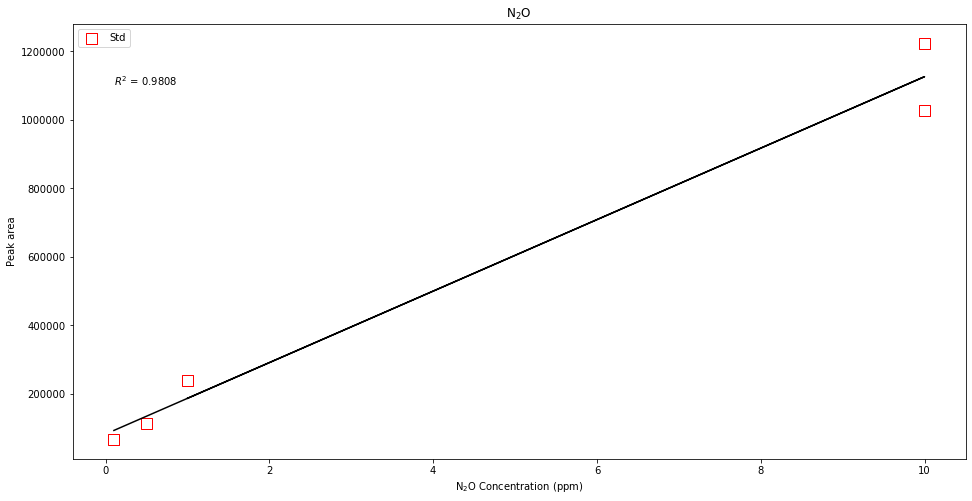

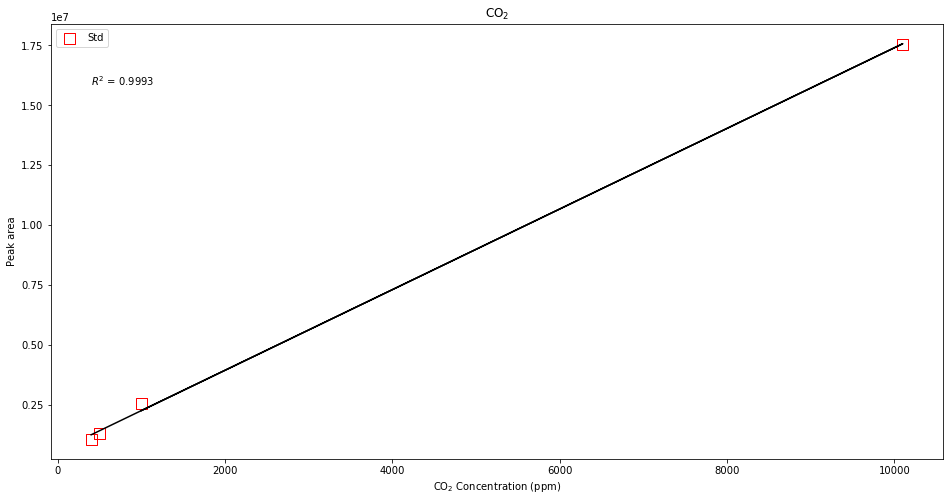

In [5]:
# Separate out N2O, CH4 and CO2 standards
N2Ostd  = stds[stds['sample'].str.contains("N2OStd")].copy()
CO2std  = stds[stds['sample'].str.contains("CO2Std")].copy()
CH4std  = stds[stds['sample'].str.contains("CH4Std")].copy()

# Play around with CO2 standard curve
CO2std.loc[999, 'CO2_peak'] = 1065942 # Add 400 ppm from QC
CO2std.loc[999, 'ppm'] = 400 # Add 400 ppm from QC

# Plot the standards with linear regression trendline
plot_standards(N2Ostd['ppm'],N2Ostd['N2O_peak'],r'N$_2$O')
plot_standards(CO2std['ppm'],CO2std['CO2_peak'],r'CO$_2$')

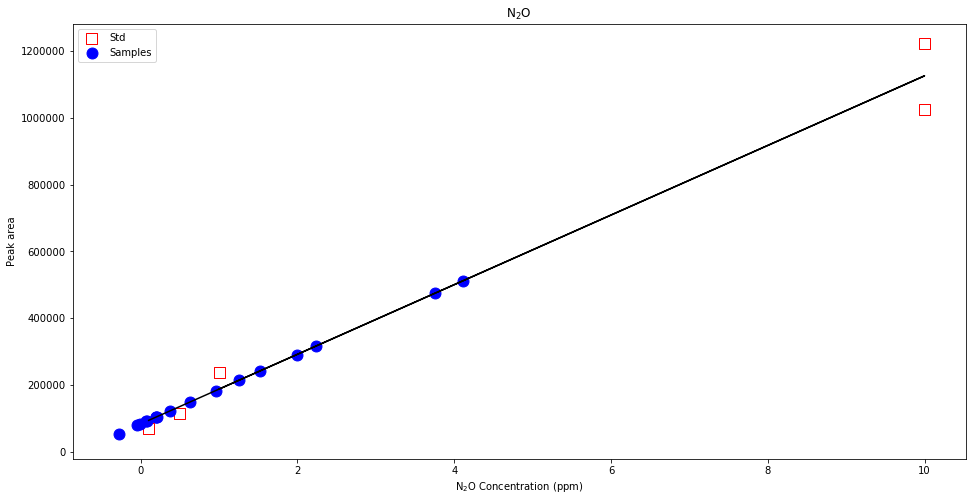

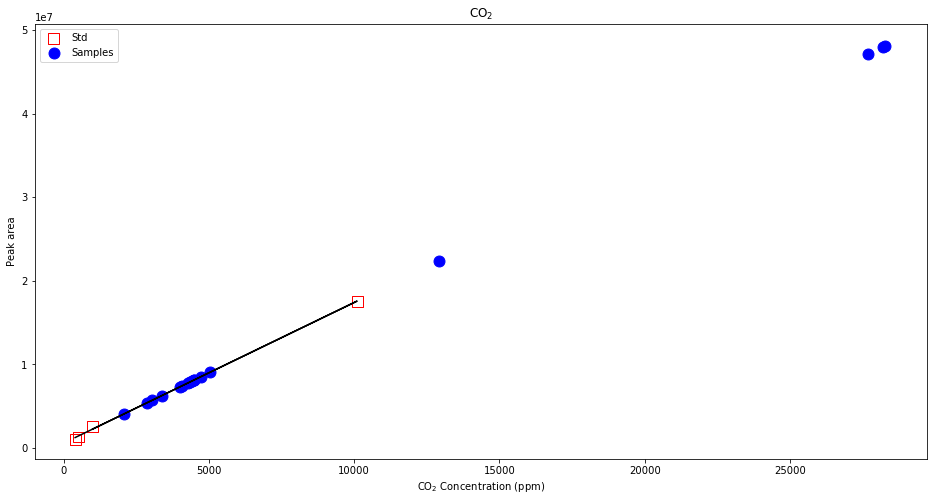

In [6]:
# Now, plot the standards along with the samples
plot_samples(samples['N2O_peak'], N2Ostd['ppm'], N2Ostd['N2O_peak'], r"N$_2$O")
plot_samples(samples['CO2_peak'], CO2std['ppm'], CO2std['CO2_peak'], r"CO$_2$")

In [7]:
# Since the data look good, export the sample concentrations to a text file
saveoutput = save_sampleconc_new(N2Ostd['ppm'], N2Ostd['N2O_peak'], 
                                 CO2std['ppm'], CO2std['CO2_peak'], 
                                 CH4std['ppm'], CH4std['CH4_peak'], 
                                 samples, "../processed_data/RVT_TracerTest_GasConcentrations_20190509.txt", 
                                 write_to_datafile=True)
print(saveoutput)

   vial location depth       date method    dup  N2O_conc  N2O_bdl  \
0     2     PTT0    30 2019-03-27      G  False  0.050500     True   
4    10     NTC1   110 2019-03-27      G  False  0.189017    False   
5     7     NTC1    20 2019-03-27      G  False  0.050500     True   
6     8     NTC1    50 2019-03-27      G  False  0.050500     True   
7     9     NTC1    80 2019-03-27      G  False  0.201123    False   
8     2     NTT1    30 2019-03-27      G  False  0.630637    False   
9     3     NTT1    60 2019-03-27      G  False  1.257652    False   
10    4     NTT1    90 2019-03-27      G  False  1.518353    False   
11    5     PTT0   120 2019-03-27      G  False  0.378505    False   
12    6     PTT0   150 2019-03-27      H  False  0.050500     True   
13    7     PTT0   150 2019-03-27      H  False  0.050500     True   
14    3     PTT0    60 2019-03-27      G  False  0.208407    False   
15    4     PTT0    90 2019-03-27      G  False  0.955565    False   
16   12     PTT1   1